# ADA Project: 2018's Best hit Recipe 🎙🎵

In [1]:
import numpy as np
import pandas as pd

import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob
import time
import csv

import h5py
import hdf5_getters
from hdf5_getters import *

from operator import methodcaller

In [2]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource, show
from bokeh.models import HoverTool, PanTool, BoxZoomTool, WheelZoomTool, ZoomInTool, ZoomOutTool, Title
from bokeh.models.tickers import FixedTicker
from bokeh.models.formatters import FuncTickFormatter
output_notebook()

Loading BokehJS ...

In [3]:
def hover_scatter_plot(source, hover, title, xlabel, ylabel, xtickslabels, ytickslabels, orientation, url, width, height): 
    p = figure(plot_width=width, plot_height=height, tools=[hover, PanTool(), BoxZoomTool(), WheelZoomTool(), ZoomInTool(), ZoomOutTool()],
           title=title,
           x_axis_label=xlabel,
           y_axis_label=ylabel)
    
    p.circle('x', 'y', size=4, source=source)

    if(orientation == 'vertical' and (xtickslabels != None)):
        p.xaxis.formatter = FuncTickFormatter(code="""
            var labels = %s;
            return labels[tick];
            """ % xtickslabels)
        p.xaxis.ticker = FixedTicker(ticks=np.arange(0,len(xtickslabels)))
        p.xaxis.major_label_orientation = np.pi/2
    elif(orientation == 'horizontal' and (ytickslabels != None)):
        p.yaxis.formatter = FuncTickFormatter(code="""
            var labels = %s;
            return labels[tick];
            """ % ytickslabels)
        p.yaxis.ticker = FixedTicker(ticks=np.arange(0,len(ytickslabels)))
        p.yaxis.major_label_orientation = 'horizontal'
        
    p.add_layout(Title(text='Data from: ' + url, align='left'), 'below')
   
    p.background_fill_color = (229, 228, 226)
    p.background_fill_alpha = 0.7
    
    show(p)

In [4]:
def count_all_files(base_directory, ext='.h5') :
    cnt = 0
    for root, dirs, files in os.walk(base_directory):
        files = glob.glob(os.path.join(root,'*'+ext))
        cnt += len(files)
    return cnt

In [5]:
def get_all(getter, base_directory, ext='.h5'):
    values = []
    for root, dirs, files in os.walk(base_directory):
        files = glob.glob(os.path.join(root,'*'+ext))
        for f in files:
            h5 = hdf5_getters.open_h5_file_read(f)
            values.append( getter(h5) )
            h5.close()
    return values

In [6]:
def get_file_fields(file, all_getters):
    fields = []
    for getter_name in all_getters:
        getter = getattr(hdf5_getters, getter_name)
        fields.append(getter(h5))
    return fields

In [168]:
def flatmap(top_list):
    return [item for sublist in top_list for item in sublist]

In [7]:
base_directory = './millionsongsubset_full/MillionSongSubset/data'

In [8]:
print('Number of songs:', count_all_files(base_directory))

Number of songs: 10000


In [9]:
all_getters = list(filter(lambda x: x[:3] == 'get',hdf5_getters.__dict__.keys()))
print(all_getters)
print('Number of getters:', len(all_getters))

['get_num_songs', 'get_artist_familiarity', 'get_artist_hotttnesss', 'get_artist_id', 'get_artist_mbid', 'get_artist_playmeid', 'get_artist_7digitalid', 'get_artist_latitude', 'get_artist_longitude', 'get_artist_location', 'get_artist_name', 'get_release', 'get_release_7digitalid', 'get_song_id', 'get_song_hotttnesss', 'get_title', 'get_track_7digitalid', 'get_similar_artists', 'get_artist_terms', 'get_artist_terms_freq', 'get_artist_terms_weight', 'get_analysis_sample_rate', 'get_audio_md5', 'get_danceability', 'get_duration', 'get_end_of_fade_in', 'get_energy', 'get_key', 'get_key_confidence', 'get_loudness', 'get_mode', 'get_mode_confidence', 'get_start_of_fade_out', 'get_tempo', 'get_time_signature', 'get_time_signature_confidence', 'get_track_id', 'get_segments_start', 'get_segments_confidence', 'get_segments_pitches', 'get_segments_timbre', 'get_segments_loudness_max', 'get_segments_loudness_max_time', 'get_segments_loudness_start', 'get_sections_start', 'get_sections_confidence'

#### Saving and retrieving the dataframe

In [10]:
def save_to_csv(data, filename, folder='./data/'):
    #note: newline='' prevents Python 3 from adding a new line after writing each row
    with open(folder+filename, 'w', newline='') as f:
        writer = csv.writer(f)
        
        if(type(data[0]) == np.ndarray):
            #unfold the pandas series into an array of array
            array = [subarray for subarray in data]
            writer.writerows(array)
        else:
            writer.writerow(data)

In [11]:
def retrieve_csv(filename, retrieve_as='object', folder='./data/'):
    data = []
    with open(folder+filename, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            data.append(row)
            
    if(retrieve_as in ['integer', 'signed', 'unsigned', 'float']):
        data = [pd.to_numeric(item, errors='coerce', downcast=retrieve_as) if(len(item) > 0) else item for item in data]
            
    if(len(data) == 1):
        return data[0]
    else:
        return data

#### Building the dataframe (only subset)

*note: skip this section if the dataframe has  already been saved to .csv*

In [34]:
#iterate over all the .h5 files, starting from the base directory
#note: takes between ~8 to ~10 minutes
start_time = time.time()

values = []
ext = '.h5'

for root, dirs, files in os.walk(base_directory):
    files = glob.glob(os.path.join(root, '*'+ext))
    for f in files:
        h5 = hdf5_getters.open_h5_file_read(f)
        values.append(get_file_fields(h5, all_getters))
        h5.close()        

print("--- Execution time: %s seconds ---" % (time.time() - start_time))

--- Execution time: 610.5978236198425 seconds ---


In [35]:
#create the column names from the getter names
#strip the name of 'get_'
column_names = [name[4:].replace('_', ' ') for name in all_getters]

In [36]:
#create a dataframe with the given column names
data = pd.DataFrame(columns=column_names)
data.head()

--- Execution time: 0.01060795783996582 seconds ---


,num songs,artist familiarity,artist hotttnesss,artist id,artist mbid,artist playmeid,artist 7digitalid,artist latitude,artist longitude,artist location,...,sections confidence,beats start,beats confidence,bars start,bars confidence,tatums start,tatums confidence,artist mbtags,artist mbtags count,year


In [37]:
#fill the dataframe row by row
start_time = time.time()
nb_entries = len(values)
for i in range(0, nb_entries):
    data.loc[i] = values[i]
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

In [18]:
data.head(1)

,num songs,artist familiarity,artist hotttnesss,artist id,artist mbid,artist playmeid,artist 7digitalid,artist latitude,artist longitude,artist location,...,sections confidence,beats start,beats confidence,bars start,bars confidence,tatums start,tatums confidence,artist mbtags,artist mbtags count,year
0,1,0.581794,0.401998,b'ARD7TVE1187B99BFB1',b'e77e51a5-4761-45b3-9847-2051f811e366',4479,165270,NaN,NaN,b'California - LA',...,"[1.0, 1.0, 0.218, 0.133, 0.384, 0.326, 0.373, ...","[0.58521, 1.19196, 1.78893, 2.37813, 2.94247, ...","[0.834, 0.851, 0.65, 0.635, 0.532, 0.753, 0.62...","[0.58521, 2.94247, 5.14371, 7.74554, 10.36149,...","[0.643, 0.746, 0.722, 0.095, 0.091, 0.362, 0.4...","[0.28519, 0.58521, 0.89422, 1.19196, 1.49119, ...","[0.779, 0.734, 0.674, 0.637, 0.597, 0.532, 0.4...",[],[],0


#### Writing the dataframe to .csv
*note: skip this section if the dataframe has  already been saved to .csv*

In [44]:
column_names = [name[4:].replace('_', ' ') for name in all_getters]

In [47]:
count = 0

start_time = time.time()
for column_name in column_names:
    count += 1
    print(count, column_name)
    save_to_csv(data[column_name], folder+column_name.replace(' ', '_')+'.csv')
    
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

1 num songs
2 artist familiarity
3 artist hotttnesss
4 artist id
5 artist mbid
6 artist playmeid
7 artist 7digitalid
8 artist latitude
9 artist longitude
10 artist location
11 artist name
12 release
13 release 7digitalid
14 song id
15 song hotttnesss
16 title
17 track 7digitalid
18 similar artists
19 artist terms
20 artist terms freq
21 artist terms weight
22 analysis sample rate
23 audio md5
24 danceability
25 duration
26 end of fade in
27 energy
28 key
29 key confidence
30 loudness
31 mode
32 mode confidence
33 start of fade out
34 tempo
35 time signature
36 time signature confidence
37 track id
38 segments start
39 segments confidence
40 segments pitches
41 segments timbre
42 segments loudness max
43 segments loudness max time
44 segments loudness start
45 sections start
46 sections confidence
47 beats start
48 beats confidence
49 bars start
50 bars confidence
51 tatums start
52 tatums confidence
53 artist mbtags
54 artist mbtags count
55 year


#### Retrieving the dataframe

The data needs to be read only once from the .h5 file structure. After that, the created dataframe is saved into multiple .csv files, one per column: it is from these files that the dataframe is loaded for the rest of the analysis.

The additional `index.csv` file specifies the datatype of each column, in particular, if a the data in the /csv file should be converted to numeric or not.

In [12]:
data = pd.DataFrame()

In [18]:
index = retrieve_csv('index.csv')
#big files...
index.remove(['segments pitches', 'float'])
index.remove(['segments timbre', 'float'])
len(index)

53

In [19]:
start_time = time.time()
for idx in index:
    print(idx)
    column_name = idx[0]
    retrieve_as = idx[1]
    filename = column_name.replace(' ', '_')+'.csv'
    data[column_name] = retrieve_csv(filename, retrieve_as=retrieve_as)

print("--- Execution time: %s seconds ---" % (time.time() - start_time))

['num songs', 'object']
['artist familiarity', 'float']
['artist hotttnesss', 'float']
['artist id', 'object']
['artist mbid', 'object']
['artist playmeid', 'object']
['artist 7digitalid', 'object']
['artist latitude', 'float']
['artist longitude', 'float']
['artist location', 'object']
['artist name', 'object']
['release', 'object']
['release 7digitalid', 'object']
['song id', 'object']
['song hotttnesss', 'float']
['title', 'object']
['track 7digitalid', 'object']
['similar artists', 'object']
['artist terms', 'object']
['artist terms freq', 'object']
['artist terms weight', 'object']
['analysis sample rate', 'object']
['audio md5', 'object']
['danceability', 'float']
['duration', 'float']
['end of fade in', 'float']
['energy', 'float']
['key', 'object']
['key confidence', 'float']
['loudness', 'float']
['mode', 'object']
['mode confidence', 'float']
['start of fade out', 'float']
['tempo', 'float']
['time signature', 'object']
['time signature confidence', 'float']
['track id', 'obj

In [15]:
data.head(1)

,num songs,artist familiarity,artist hotttnesss,artist id,artist mbid,artist playmeid,artist 7digitalid,artist latitude,artist longitude,artist location,...,sections confidence,beats start,beats confidence,bars start,bars confidence,tatums start,tatums confidence,artist mbtags,artist mbtags count,year
0,1,0.581794,0.401998,b'ARD7TVE1187B99BFB1',b'e77e51a5-4761-45b3-9847-2051f811e366',4479,165270,NaN,NaN,b'California - LA',...,"[1.0, 1.0, 0.218, 0.133, 0.384, 0.326, 0.373, ...","[0.58521, 1.19196, 1.78893, 2.37813, 2.94247, ...","[0.834, 0.851, 0.65, 0.635, 0.532, 0.753, 0.62...","[0.58521, 2.94247, 5.14371, 7.74554, 10.36149,...","[0.643, 0.746, 0.722, 0.095, 0.091, 0.362, 0.4...","[0.28519, 0.58521, 0.89422, 1.19196, 1.49119, ...","[0.779, 0.734, 0.674, 0.637, 0.597, 0.532, 0.4...",[],[],0


In [81]:
data['beats start'] = retrieve_csv('beats_start.csv', retrieve_as='float')
data['beats confidence'] = retrieve_csv('beats_confidence.csv', retrieve_as='float')

In [165]:
data['artist terms weight'] = retrieve_csv('artist_terms_weight.csv', retrieve_as='float')

#### Formatting the strings

In [138]:
def clean_string_column(data):
    return data.apply(lambda x: [y.replace('b\'', '')
                                         .replace('b"', '')
                                         .replace('"', '')
                                         .replace('\'', '') for y in x] if(type(x) == list) 
                                                                        else x.replace('b\'', '')
                                                                              .replace('b"', '')
                                                                              .replace('"', '')
                                                                              .replace('\'', ''))


In [140]:
#single values
data['title'] = clean_string_column(data['title'])
data['artist id'] = clean_string_column(data['artist id'])
data['artist mbid'] = clean_string_column(data['artist mbid'])
data['artist location'] = clean_string_column(data['artist location'])

#arrays
data['artist mbtags'] = clean_string_column(data['artist mbtags'])
data['artist terms'] = clean_string_column(data['artist terms'])

#### Basic statistics

- ranges, mean, median, ...
- graphs

We give a basic overview of the (most important) features of the songs, using pandas `describe()` method.

In [116]:
def describe(data, column, include_undefined):
    if(include_undefined):
        return pd.DataFrame(data[column]).describe()
    else:
        return pd.DataFrame(data[data[column] != 0][column]).describe()          

In [117]:
def set_ticks_wtih_step(ax, step):
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::step])
    ax.xaxis.set_ticklabels(ticklabels[::step]);

#### Song hotttnesss

Since we are interested in determining which features make a song popular, the `song hotttnesss` feature will prove to be particularly useful. 
The `song hotttnesss` of each song, on a scale from 0 to 1, is an indicator of its popularity in 2010 according to The Echo Nest.

In [151]:
describe(data, 'song hotttnesss', True)

,song hotttnesss
count,5648.000000
mean,0.342822
std,0.247218
min,0.000000
25%,0.000000
50%,0.360371
75%,0.537504
max,1.000000


From the Million Song Dataset documentation, a `song hotttness` of 0 does not mean the feature has not been analysed for this song, but that the `song hotttnesss` is *effectively* 0.

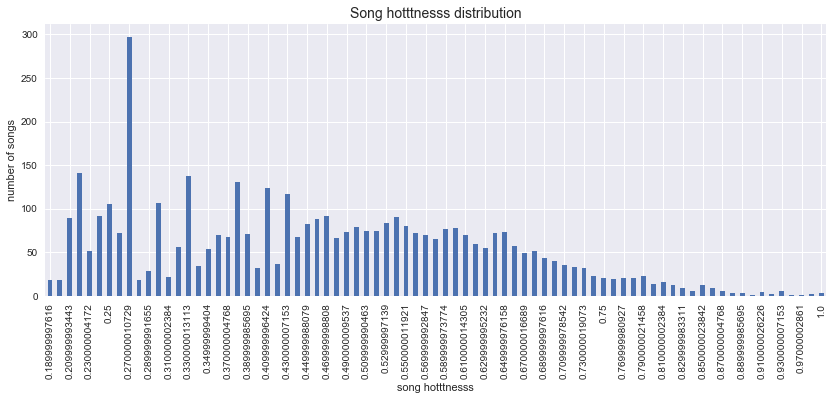

In [153]:
#TODO: check if song hotttnesss = 0 effectively 0

#round the 'song hotttnesss' to the nearest hundredth, in order to limit the number of bins
ax = round(data[data['song hotttnesss'] > 0]['song hotttnesss'], 2).value_counts()\
                                                                   .sort_index()\
                                                                   .plot(kind='bar',
                                                                         grid=True,
                                                                         figsize=(14, 5));

ax.set_title('Song hotttnesss distribution', fontsize=14)
ax.set_xlabel('song hotttnesss')
ax.set_ylabel('number of songs');
set_ticks_wtih_step(ax, 2)

The distribution of the `song hotttness` does not seem to correspond to a particular known distribution.
Most of the songs have an average to low `song hotttnesss`.
This will still be useful for determining what are the features that could make a song unpopular.

#### Release year

In [155]:
describe(data, 'year', True)

,year
count,10000.000000
mean,934.704600
std,996.650657
min,0.000000
25%,0.000000
50%,0.000000
75%,2000.000000
max,2010.000000


Like for the `song hotttnesss`, we see that the minimum `year` is 0. Here however, 0 actually stands for `undefined`. In our statistics, we will therefore not include those songs for which a certain feature is undefined, as this would bias the distributions.

In [156]:
describe(data, 'year', False)

,year
count,4680.000000
mean,1997.232051
std,11.686691
min,1926.000000
25%,1993.000000
50%,2001.000000
75%,2006.000000
max,2010.000000


Now the earliest `year` is 1926, which indeed appears to  be more realistic. The majority of the songs in the dataset has been released in the last 20 years, although the most recent ones date back to 2010 already. 

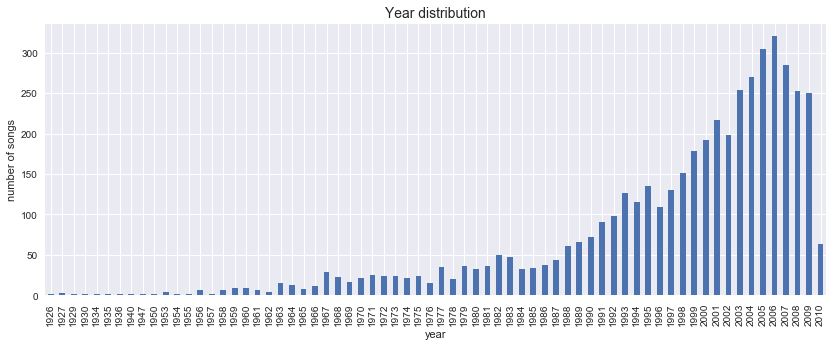

In [154]:
ax = data[data['year'] > 0]['year'].value_counts()\
                                   .sort_index()\
                                   .plot(kind='bar',
                                         grid=True,
                                         figsize=(14, 5));
        
ax.set_title('Year distribution', fontsize=14)
ax.set_xlabel('year')
ax.set_ylabel('number of songs');

Most of the songs we are going to deal with came out in 2000 and later. Hopefully, the ones which were popular in 2011, when the Million Song Dataset was created, remain so to these days. Otherwise, predicting the 2018's best hit might prove more challenging than expected!

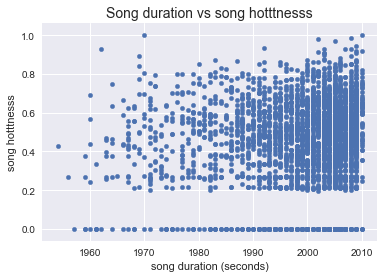

In [116]:
ax = data[data['year'] != 0].plot(kind='scatter', x='year', y='song hotttnesss')
ax.set_title('Song duration vs song hotttnesss', fontsize=14)
ax.set_xlabel('song duration (seconds)')
ax.set_ylabel('song hotttnesss');

In [145]:
data_valid= data[(data['song hotttnesss'] != 0) & (data['year'] != 0)]
source = ColumnDataSource(data=dict(
    y=data_valid['song hotttnesss'],
    x=data_valid['year'],
    title=data_valid['title'],
    artist=data_valid['artist name'],
    song_hotttnesss=data_valid['song hotttnesss'],
    year=data_valid['year']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Artist', '@artist'),
    ('Song hotttnesss', '@song_hotttnesss'),
    ('Year', '@year')
])

hover_scatter_plot(source, hover, 
                   'Song hotttnesss vs release year', 'release year', 'song hotttnesss',
                    None, None, 'horizontal', 'MSD', 800, 400)

Most songs with the highest `song hotttnesss` are among the most recent ones. 
This may be because they are genuinely more popular, or also because the MSD or the MSD subset sampled more songs from these last years.
*Immigrant Song* from Led Zeppelin appears to be an early hit.

#### Artist hotttnesss

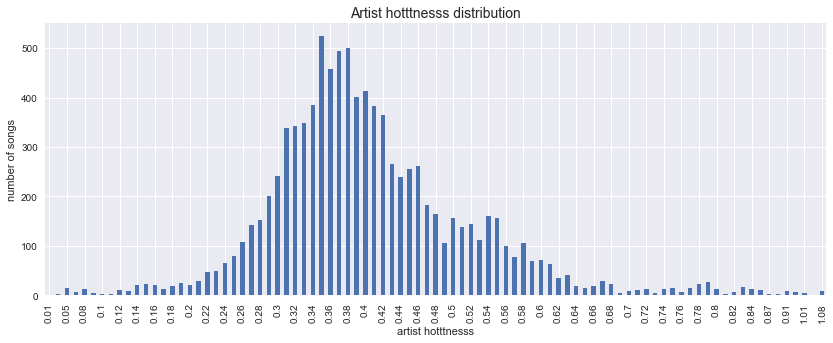

In [143]:
#round the 'song hotttnesss' to the nearest hundredth, in order to limit the number of bins
ax = round(data[data['artist hotttnesss'] > 0]['artist hotttnesss'], 2).value_counts()\
                                                                       .sort_index()\
                                                                       .plot(kind='bar',
                                                                             grid=True,
                                                                             figsize=(14, 5));
ax.set_title('Artist hotttnesss distribution', fontsize=14)
ax.set_xlabel('artist hotttnesss')
ax.set_ylabel('number of songs');
set_ticks_wtih_step(ax, 2)

*Oh....! Gaussian-like distribution...! ... or is it lognormal...?*

#### Song duration

In [30]:
describe(data, 'duration', False)

,duration
count,10000.000000
mean,238.507278
std,114.137314
min,1.044440
25%,176.032196
50%,223.059143
75%,276.375061
max,1819.767700


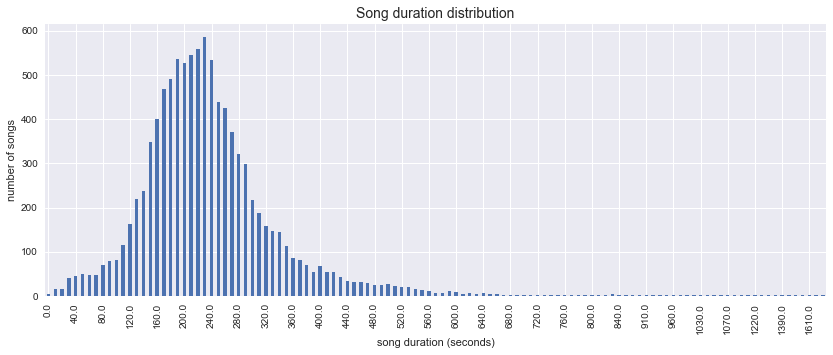

In [146]:
ax = round(data['duration'], -1).value_counts()\
                                .sort_index()\
                                .plot(kind='bar', 
                                      grid=True,
                                      figsize=(14, 5));
        
ax.set_title('Song duration distribution', fontsize=14)
ax.set_xlabel('song duration (seconds)')
ax.set_ylabel('number of songs')
set_ticks_wtih_step(ax, 4)

The `song duration` may be following a lognormal distribution.
The data is asymetric, with most outliers lying to the right, and some to the left: the most common distributions for this type of data are the lognormal, the Gamma, the Weibull distributions.
Since many natural phenomenons related to some *length* have been observed to follow a lognormal ditribution, then most likely so does the `song duration`.

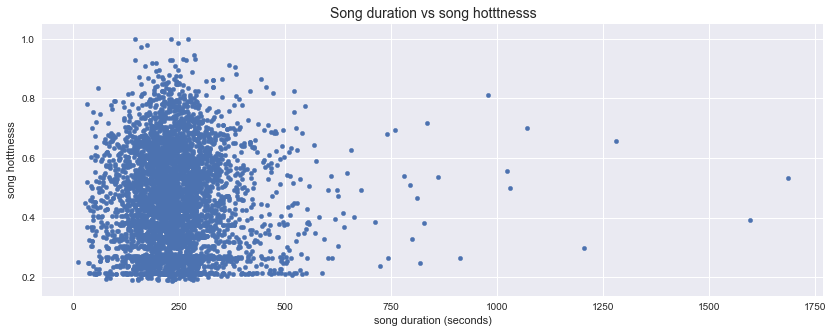

In [29]:
ax = data[data['song hotttnesss'] != 0].plot(kind='scatter', x='duration', y='song hotttnesss', figsize=(14,5));
ax.set_title('Song duration vs song hotttnesss', fontsize=14)
ax.set_xlabel('song duration (seconds)')
ax.set_ylabel('song hotttnesss');

In [136]:
data_valid= data[data['song hotttnesss'] != 0]
source = ColumnDataSource(data=dict(
    y=data_valid['song hotttnesss'],
    x=data_valid['duration'],
    title=data_valid['title'],
    artist=data_valid['artist name'],
    song_hotttnesss=data_valid['song hotttnesss'],
    duration=data_valid['duration']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Artist', '@artist'),
    ('Song hotttnesss', '@song_hotttnesss'),
    ('Duration', '@duration')
])

hover_scatter_plot(source, hover, 
                   'Song hotttnesss vs song duration', 'song duration (seconds)', 'song hotttnesss',
                    None, None, 'horizontal', 'MSD', 800, 400)

There does not seem to be any particular correlation between the `song hotttnesss` and the `song duration`.
We observe that the most popular songs are neither particularly long or particularly short, but have a `song duration` around the mean.

#### Non-evaluated features

Unfortunately, some features such as `energy` or `danceability` happen to not have been evaluated for any of the songs in the dataset. This means we will not be able to use them in our analysis.

In [153]:
describe(data, 'energy', True)

,energy
count,10000.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [259]:
describe(data, 'danceability', True)

,danceability
count,10000.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


#### Artist terms

In [69]:
top_list = data['artist terms']
artist_terms_all = [item for sublist in top_list for item in sublist]
artist_terms_distinct = set(artist_terms_all)

print('Total number of artist terms:', len(artist_terms_all))
print('Number of distinct artist terms:', len(artist_terms_distinct))

Total number of artist terms: 266611
Number of distinct artist terms: 3502


In [70]:
serie = pd.Series(artist_terms_all).value_counts()

In [71]:
serie.sort_values(ascending=False).head(10)

rock                6493
pop                 5476
electronic          4453
jazz                3596
united states       3084
hip hop             2926
alternative rock    2753
folk                2598
alternative         2586
soul                2491
dtype: int64

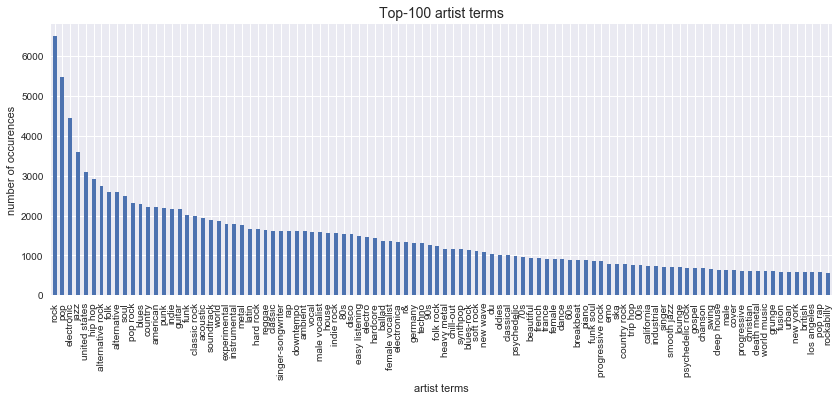

In [72]:
top = 100
ax = serie.sort_values(ascending=False).head(top)\
                                       .plot(kind='bar',
                                             grid=True,
                                             figsize=(14, 5));
    
ax.set_title('Top-' + str(top) + ' artist terms', fontsize=14)
ax.set_xlabel('artist terms')
ax.set_ylabel('number of occurences');

It would seem the songs in the MSD subset (and probably the MSD dataset in general) are heavily rock and pop oriented. (and western oriented too)

In [337]:
threshold = 0.0
top_songs = data[data['song hotttnesss'] >= threshold]

In [338]:
top_artist_terms = flatmap(top_songs['artist terms'])
top_artist_terms_weight = flatmap(top_songs['artist terms weight'])

In [339]:
list_tuples = list(zip(top_artist_terms, top_artist_terms_weight))

In [340]:
from collections import defaultdict

groups = defaultdict(list)

#group by term
for item in list_tuples:
    groups[item[0]].append(item[1])

#compute the mean
for item in groups.items():
    groups[item[0]] = (np.mean(item[1]), np.std(item[1]))
                       

In [341]:
top_artist_terms_sorted = sorted(groups.items(), key=lambda value: value[1][0], reverse=True)

In [342]:
df = pd.DataFrame()
df['artist terms'] = [item[0] for item in top_artist_terms_sorted]
df['mean artist terms weight'] = [item[1][0] for item in top_artist_terms_sorted]
df['std artist terms weight'] = [item[1][1] for item in top_artist_terms_sorted]
df.head(20)

,artist terms,mean artist terms weight,std artist terms weight
0,celtic punk,1.000000,0.000000
1,slack key guitar,1.000000,0.000000
2,early music,1.000000,0.000000
3,mandarin pop,1.000000,0.000000
4,marrabenta,1.000000,0.000000
5,mozambique,1.000000,0.000000
6,dirty rap,1.000000,0.000000
7,filk,1.000000,0.000000
8,bulerias,1.000000,0.000000
9,queercore,1.000000,0.000000


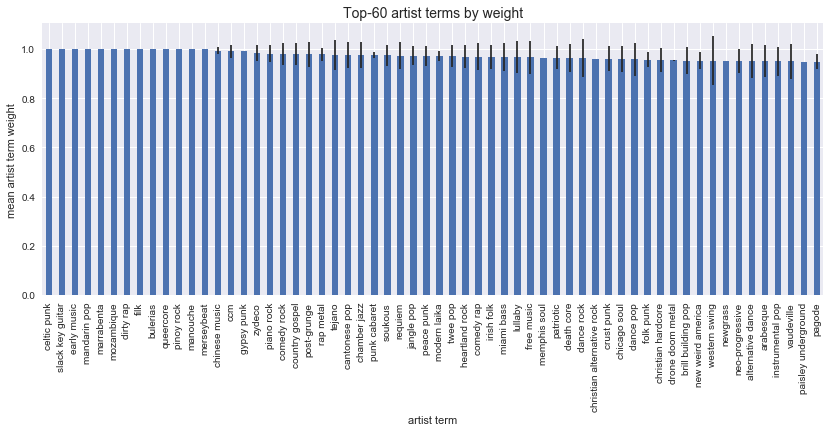

In [343]:
top = 60
error = df.head(top)['std artist terms weight']
ax = df.head(top)['mean artist terms weight'].plot(kind='bar', yerr=error, grid=True, figsize=(14, 5));

ax.set_title('Top-' + str(top) + ' artist terms by weight', fontsize=14)
ax.set_xlabel('artist term')
ax.set_ylabel('mean artist term weight')
ax.set_xticklabels(df['artist terms']);

In [270]:
#consider regrouping artist terms into less groups

#### Beats

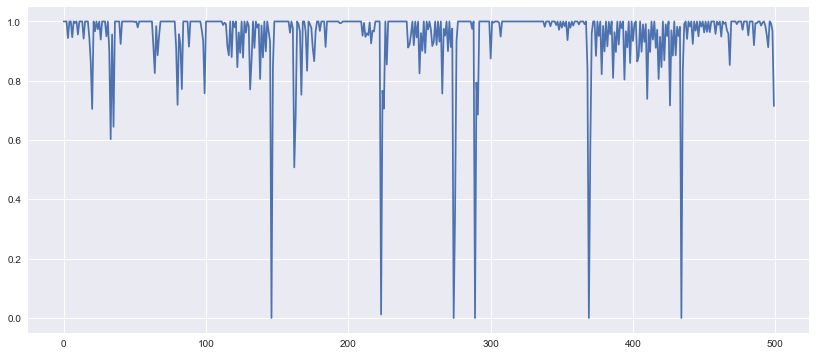

In [262]:
idx = 9
plt.figure(figsize=(14, 6))
serie = data['beats confidence'][idx]
plt.plot(np.arange(0,len(serie)), serie);

In [85]:
all_getters

['get_num_songs',
 'get_artist_familiarity',
 'get_artist_hotttnesss',
 'get_artist_id',
 'get_artist_mbid',
 'get_artist_playmeid',
 'get_artist_7digitalid',
 'get_artist_latitude',
 'get_artist_longitude',
 'get_artist_location',
 'get_artist_name',
 'get_release',
 'get_release_7digitalid',
 'get_song_id',
 'get_song_hotttnesss',
 'get_title',
 'get_track_7digitalid',
 'get_similar_artists',
 'get_artist_terms',
 'get_artist_terms_freq',
 'get_artist_terms_weight',
 'get_analysis_sample_rate',
 'get_audio_md5',
 'get_danceability',
 'get_duration',
 'get_end_of_fade_in',
 'get_energy',
 'get_key',
 'get_key_confidence',
 'get_loudness',
 'get_mode',
 'get_mode_confidence',
 'get_start_of_fade_out',
 'get_tempo',
 'get_time_signature',
 'get_time_signature_confidence',
 'get_track_id',
 'get_segments_start',
 'get_segments_confidence',
 'get_segments_pitches',
 'get_segments_timbre',
 'get_segments_loudness_max',
 'get_segments_loudness_max_time',
 'get_segments_loudness_start',
 'ge